In [16]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from medmnist import BreastMNIST, INFO
import pennylane as qml
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA: 12.4


In [18]:
info = INFO['breastmnist']
data_flag = 'breastmnist'
DataClass = BreastMNIST

task = info['task']  
n_channels = info['n_channels']
n_classes = len(info['label'])
print(f"Number of classes: {n_classes}")

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_train = DataClass(split='train', transform=train_transform, download=True)
data_test = DataClass(split='test', transform=eval_transform, download=True)
data_eval = DataClass(split='val', transform=eval_transform, download=True)

batch_size = 32

dataloader_train = data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)
dataloader_eval = data.DataLoader(dataset=data_eval, batch_size=batch_size, shuffle=False)

Number of classes: 2
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz


In [19]:
class Quanvolution(nn.Module):
    def __init__(self, stride=2, device="lightning.gpu", wires=4, circuit_layers=1, n_rotations=8, out_channels=4, seed=None):
        super(Quanvolution, self).__init__()
        
        self.wires = wires
        self.dev = qml.device(device, wires=self.wires)
        
        self.stride = stride
        self.out_channels = min(out_channels, wires)
        
        if seed is None:
            seed = np.random.randint(low=0, high=10e6)
        
        @qml.qnode(device=self.dev, interface="torch")
        def circuit(inputs, weights):
            n_inputs=4
            for j in range(n_inputs):
                qml.RY(inputs[j], wires=j)
            qml.templates.layers.RandomLayers(weights, wires=list(range(self.wires)), seed=seed)
            
            return [qml.expval(qml.PauliZ(j)) for j in range(self.out_channels)]
        
        weight_shapes = {"weights": [circuit_layers, n_rotations]}
        self.circuit = qml.qnn.TorchLayer(circuit, weight_shapes=weight_shapes)
        
    def forward(self, img):
        bs, h, w, ch = img.size()
        if ch > 1:
            img = img.mean(axis=-1).reshape(bs, h, w, 1)
                        
        kernel_size = 2        
        h_out = (h-kernel_size) // self.stride + 1
        w_out = (w-kernel_size) // self.stride + 1
        
        
        out = torch.zeros((bs, h_out, w_out, self.out_channels))
        
        for b in range(bs):
            for j in range(0, h_out, self.stride):
                for k in range(0, w_out, self.stride):
                    q_results = self.circuit(
                        inputs=torch.Tensor([
                            img[b, j, k, 0],
                            img[b, j, k + 1, 0],
                            img[b, j + 1, k, 0],
                            img[b, j + 1, k + 1, 0]
                        ])
                    )
                    for c in range(self.out_channels):
                        out[b, j // kernel_size, k // kernel_size, c] = q_results[c]        
        return out

In [20]:
class Quanvolution4x1Model(nn.Module):
    def __init__(self, output_size=(14, 14), patch_size=2, n_qubits=4, num_classes=2):
        super(Quanvolution4x1Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes
        
        self.quanv = Quanvolution()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(output_size[0] * output_size[1] * n_qubits, num_classes)

    def forward(self, x):
        if x.dim() == 3:  
            x = x.unsqueeze(1) 

        x = x.permute(0, 2, 3, 1)
        x = self.quanv(x).to(device)
        x = torch.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [21]:
model = Quanvolution4x1Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20

In [ ]:
last_model_path = "/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/trainable/BreastMNIST/28x28/1/last_model.pth"
checkpoint_frequency = 2

best_val_loss = float("inf")

train_losses = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_aucs = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    model.train()
    total_loss = 0.0
    print("\n[Training]")
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader_train, desc="Training Batches", bar_format="{desc}: {n}/{total}")):
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        batch_accuracy = accuracy_score(
            labels.cpu().numpy(), output.argmax(dim=1).cpu().numpy()
        )

        print(f"Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.3f}")

        if hasattr(model, 'quanv') and hasattr(model.quanv, 'circuit'):
            print("\nGradients Layer 0:")
            print(model.quanv.circuit.weights.grad)

    epoch_train_loss = total_loss / len(dataloader_train)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}")

    scheduler.step()

    model.eval()
    val_loss = 0.0
    val_labels, val_predictions = [], []

    print("\n[Validation]")
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader_eval, desc="Validation Batches", bar_format="{desc}: {n}/{total}")):
            images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            val_labels.append(labels)
            val_predictions.append(output)

            batch_accuracy = accuracy_score(
                labels.cpu().numpy(), output.argmax(dim=1).cpu().numpy()
            )
            print(f"Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.3f}")

    epoch_val_loss = val_loss / len(dataloader_eval)
    val_losses.append(epoch_val_loss)
    val_labels = torch.cat(val_labels)
    val_predictions = torch.cat(val_predictions)

    val_accuracy = accuracy_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy())
    val_precision = precision_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_recall = recall_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_f1 = f1_score(
        val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(),
        average="weighted", zero_division=0)
    val_auc = roc_auc_score(
        val_labels.cpu().numpy(), val_predictions[:, 1].cpu().numpy())

    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    val_aucs.append(val_auc)

    print(
        f"\nEpoch {epoch + 1} Summary:\n"
        f"Train Loss: {epoch_train_loss:.4f}, "
        f"Val Loss: {epoch_val_loss:.4f}, "
        f"Accuracy: {val_accuracy:.3f}, "
        f"Precision: {val_precision:.3f}, "
        f"Recall: {val_recall:.3f}, "
        f"F1: {val_f1:.3f}, "
        f"AUC: {val_auc:.3f}"
    )

    if (epoch + 1) % checkpoint_frequency == 0:
        checkpoint_path = f"/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/trainable/BreastMNIST/28x28/1/model_checkpoint_epoch_{epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved.")

torch.save(model.state_dict(), last_model_path)
print("Last model saved.")


Epoch 1/20

[Training]


Training Batches: 0/18

Loss: 0.6985, Accuracy: 0.438

Gradients Layer 0:


Training Batches: 1/18

tensor([[ 3.3048e-04,  3.3048e-04, -2.3225e-04, -2.8491e-03,  1.1082e-18,
          6.4385e-19, -1.2022e-03,  1.2967e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.8455, Accuracy: 0.625

Gradients Layer 0:
tensor([[ 4.9591e-02,  4.9591e-02, -4.2687e-02,  5.4743e-03,  1.6466e-18,
         -2.9533e-18, -1.5894e-01,  4.6301e-19]], device='cuda:0')


Training Batches: 3/18

Loss: 0.6229, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 6.5524e-03,  6.5524e-03, -5.2248e-03,  2.5791e-03,  8.0713e-21,
         -2.4555e-19, -2.2379e-02,  2.4251e-19]], device='cuda:0')


Training Batches: 4/18

Loss: 0.6786, Accuracy: 0.594

Gradients Layer 0:
tensor([[-1.0376e-02, -1.0376e-02,  2.0452e-03, -2.1321e-02,  2.1008e-19,
          1.4184e-19,  3.1882e-02,  7.7783e-21]], device='cuda:0')


Training Batches: 5/18

Loss: 0.6299, Accuracy: 0.719

Gradients Layer 0:
tensor([[-1.4749e-02, -1.4749e-02,  4.1081e-03,  8.7353e-03, -5.6998e-19,
          1.2624e-18,  4.3324e-02, -2.1636e-19]], device='cuda:0')


Training Batches: 6/18

Loss: 0.4769, Accuracy: 0.844

Gradients Layer 0:
tensor([[-1.9553e-02, -1.9553e-02,  1.2203e-02,  6.5726e-03, -4.5635e-20,
         -6.5371e-20,  5.7846e-02, -3.2970e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.6362, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 3.0130e-02,  3.0130e-02, -2.2686e-02,  4.0847e-02,  3.0849e-19,
         -9.3515e-19, -8.9653e-02, -6.4513e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.5725, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 2.9699e-02,  2.9699e-02, -2.2143e-02, -6.3545e-02, -5.4689e-19,
         -3.1441e-19, -8.9618e-02, -2.1614e-19]], device='cuda:0')


Training Batches: 9/18

Loss: 0.5182, Accuracy: 0.812

Gradients Layer 0:
tensor([[ 3.0491e-02,  3.0491e-02, -2.0335e-02,  2.4910e-02, -8.1811e-21,
         -1.0520e-18, -9.2101e-02,  1.0403e-19]], device='cuda:0')


Training Batches: 10/18

Loss: 0.8610, Accuracy: 0.625

Gradients Layer 0:
tensor([[ 7.4076e-02,  7.4076e-02, -5.4740e-02,  4.0601e-02, -5.9627e-20,
         -3.0492e-19, -2.1992e-01,  2.2947e-20]], device='cuda:0')


Training Batches: 11/18

Loss: 0.5409, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 7.5867e-03,  7.5867e-03, -8.4205e-03,  3.8075e-02, -4.6714e-19,
         -1.9326e-20, -2.4675e-02, -1.0785e-19]], device='cuda:0')


Training Batches: 12/18

Loss: 0.5362, Accuracy: 0.750

Gradients Layer 0:
tensor([[-1.2430e-02, -1.2430e-02,  5.0293e-03,  2.4958e-02, -5.9033e-19,
         -2.0702e-19,  3.3842e-02, -1.0039e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.6391, Accuracy: 0.656

Gradients Layer 0:
tensor([[-1.2312e-02, -1.2312e-02,  4.2747e-03,  5.4575e-03,  6.9172e-19,
         -2.2352e-19,  3.2112e-02, -1.4023e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.6430, Accuracy: 0.812

Gradients Layer 0:
tensor([[-3.8596e-02, -3.8596e-02,  5.3550e-03,  1.8481e-02,  3.6320e-19,
          1.3461e-18,  1.0709e-01,  8.0479e-22]], device='cuda:0')


Training Batches: 15/18

Loss: 0.6171, Accuracy: 0.719

Gradients Layer 0:
tensor([[-3.9999e-02, -3.9999e-02,  9.1617e-03, -2.4860e-02, -9.3006e-19,
          6.2836e-19,  1.0847e-01,  1.7112e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.5780, Accuracy: 0.781

Gradients Layer 0:
tensor([[-1.1806e-02, -1.1806e-02,  7.2291e-03, -4.5131e-02,  6.1005e-19,
         -3.8975e-19,  3.1703e-02,  2.6791e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.5314, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 1.2952e-02,  1.2952e-02, -7.5701e-03,  2.3508e-02,  3.5915e-19,
         -4.5768e-19, -3.7688e-02, -3.2977e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 1.1330, Accuracy: 0.500

Gradients Layer 0:
tensor([[ 1.4864e-01,  1.4864e-01, -9.7368e-02,  5.7705e-02, -1.5825e-17,
          2.6577e-18, -4.0895e-01,  1.7619e-18]], device='cuda:0')
Epoch 1 Training Loss: 0.6533

[Validation]


Validation Batches: 1/3

Loss: 0.6487, Accuracy: 0.719


Validation Batches: 2/3

Loss: 0.5464, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.7852, Accuracy: 0.643

Epoch 1 Summary:
Train Loss: 0.6533, Val Loss: 0.6601, Accuracy: 0.731, Precision: 0.534, Recall: 0.731, F1: 0.617, AUC: 0.675

Epoch 2/20

[Training]


Training Batches: 1/18

Loss: 0.5285, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 1.8203e-02,  1.8203e-02, -1.6398e-02,  1.0970e-02,  4.7152e-19,
          4.6035e-19, -5.1032e-02, -1.4069e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.4158, Accuracy: 0.844

Gradients Layer 0:
tensor([[-7.2588e-03, -7.2588e-03,  2.3310e-03,  4.1756e-02, -5.4099e-20,
          2.4924e-19,  2.0414e-02,  9.9275e-20]], device='cuda:0')


Training Batches: 3/18

Loss: 0.5581, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 1.6035e-02,  1.6035e-02, -1.0387e-02,  5.6504e-02,  1.8903e-18,
         -1.8508e-18, -4.6305e-02, -2.9356e-19]], device='cuda:0')


Training Batches: 4/18

Loss: 0.5607, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.0026e-03,  1.0026e-03, -3.6907e-03,  5.2412e-02,  4.0418e-19,
         -9.0064e-19, -1.2004e-03, -3.0416e-19]], device='cuda:0')


Training Batches: 5/18

Loss: 0.6361, Accuracy: 0.656

Gradients Layer 0:
tensor([[ 6.7869e-03,  6.7869e-03, -3.3957e-03, -3.3544e-02,  1.2525e-18,
         -1.8749e-18, -2.6240e-02, -9.4133e-21]], device='cuda:0')


Training Batches: 6/18

Loss: 0.5641, Accuracy: 0.719

Gradients Layer 0:
tensor([[-1.3405e-02, -1.3405e-02,  6.1038e-03,  9.7476e-02, -9.4681e-19,
         -2.6182e-18,  3.3875e-02,  1.0063e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.6011, Accuracy: 0.750

Gradients Layer 0:
tensor([[-1.5682e-02, -1.5682e-02,  4.9084e-03,  1.6959e-02,  1.3947e-18,
         -1.7241e-18,  4.2837e-02, -4.2012e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.6311, Accuracy: 0.688

Gradients Layer 0:
tensor([[-1.8617e-02, -1.8617e-02,  6.8259e-03, -2.5624e-02, -2.1487e-18,
          8.7388e-19,  4.9220e-02,  1.6497e-19]], device='cuda:0')


Training Batches: 9/18

Loss: 0.6229, Accuracy: 0.688

Gradients Layer 0:
tensor([[-2.0599e-02, -2.0599e-02,  5.4096e-03, -1.2089e-02,  1.1025e-18,
          1.2374e-18,  5.1133e-02,  2.2403e-19]], device='cuda:0')


Training Batches: 10/18

Loss: 0.5649, Accuracy: 0.781

Gradients Layer 0:
tensor([[-2.4982e-02, -2.4982e-02,  8.4382e-03, -6.8822e-03,  2.2175e-18,
          7.5198e-19,  6.3710e-02, -1.1967e-19]], device='cuda:0')


Training Batches: 11/18

Loss: 0.5686, Accuracy: 0.688

Gradients Layer 0:
tensor([[-6.7124e-03, -6.7124e-03,  3.3102e-03,  7.3042e-02,  2.0326e-18,
         -1.1754e-18,  1.6158e-02, -7.8327e-20]], device='cuda:0')


Training Batches: 12/18

Loss: 0.5041, Accuracy: 0.781

Gradients Layer 0:
tensor([[-1.3350e-02, -1.3350e-02,  6.7792e-03,  2.8437e-02,  1.4480e-18,
          2.6196e-20,  3.1840e-02,  2.5932e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.4749, Accuracy: 0.750

Gradients Layer 0:
tensor([[-1.3879e-02, -1.3879e-02, -4.6438e-03,  4.9968e-02,  3.6582e-19,
         -1.4274e-18,  3.4966e-02,  9.8561e-20]], device='cuda:0')


Training Batches: 14/18

Loss: 0.5616, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 2.6217e-02,  2.6217e-02, -1.8293e-02,  2.2826e-02,  2.0753e-19,
         -7.1586e-19, -7.2056e-02,  2.2065e-19]], device='cuda:0')


Training Batches: 15/18

Loss: 0.4195, Accuracy: 0.844

Gradients Layer 0:
tensor([[-3.1552e-03, -3.1552e-03, -2.7704e-03, -7.9055e-03,  3.6328e-18,
         -1.6646e-18,  9.0549e-03,  1.0192e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.6764, Accuracy: 0.656

Gradients Layer 0:
tensor([[ 5.1133e-02,  5.1133e-02, -4.4657e-02,  1.3936e-01,  1.0238e-18,
          1.2457e-18, -1.4431e-01,  2.9845e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.6831, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 4.4493e-02,  4.4493e-02, -3.1045e-02, -6.8841e-02,  8.5171e-20,
         -5.3930e-19, -1.2269e-01,  2.6600e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 0.2234, Accuracy: 1.000

Gradients Layer 0:
tensor([[-5.1389e-02, -5.1389e-02,  3.2936e-02,  3.1006e-01,  7.7684e-19,
          1.7771e-20,  1.4006e-01, -3.0596e-19]], device='cuda:0')
Epoch 2 Training Loss: 0.5442

[Validation]


Validation Batches: 1/3

Loss: 0.5964, Accuracy: 0.719


Validation Batches: 2/3

Loss: 0.4956, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.6174, Accuracy: 0.643

Epoch 2 Summary:
Train Loss: 0.5442, Val Loss: 0.5698, Accuracy: 0.731, Precision: 0.534, Recall: 0.731, F1: 0.617, AUC: 0.678
Checkpoint saved.

Epoch 3/20

[Training]


Training Batches: 1/18

Loss: 0.5272, Accuracy: 0.719

Gradients Layer 0:
tensor([[-1.1610e-02, -1.1610e-02, -4.1822e-03, -3.1086e-02, -9.4316e-19,
          2.9494e-18,  2.6808e-02, -1.7199e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.5633, Accuracy: 0.719

Gradients Layer 0:
tensor([[-9.4173e-04, -9.4173e-04, -1.6153e-03,  5.2728e-02, -6.8322e-19,
          2.2808e-19,  2.0190e-03,  1.8621e-19]], device='cuda:0')


Training Batches: 3/18

Loss: 0.5516, Accuracy: 0.781

Gradients Layer 0:
tensor([[-1.2154e-02, -1.2154e-02,  6.3528e-03,  2.6270e-02,  3.1074e-19,
         -9.3709e-19,  3.9762e-02,  4.0586e-20]], device='cuda:0')


Training Batches: 4/18

Loss: 0.6078, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.0986e-02,  1.0986e-02, -4.5399e-03, -1.8681e-02,  6.2107e-19,
         -2.6526e-18, -2.6952e-02,  2.0720e-19]], device='cuda:0')


Training Batches: 5/18

Loss: 0.5065, Accuracy: 0.750

Gradients Layer 0:
tensor([[-1.6979e-02, -1.6979e-02,  6.7944e-03,  1.5381e-01,  1.4053e-18,
         -8.3687e-19,  4.0887e-02,  9.3084e-20]], device='cuda:0')


Training Batches: 6/18

Loss: 0.5405, Accuracy: 0.656

Gradients Layer 0:
tensor([[-5.4046e-03, -5.4046e-03, -1.1053e-03,  6.2615e-02, -1.2517e-18,
         -2.7020e-18,  6.6077e-03, -5.1039e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.5296, Accuracy: 0.812

Gradients Layer 0:
tensor([[-2.0548e-02, -2.0548e-02,  9.1254e-03,  6.6537e-02, -2.4386e-18,
          1.2582e-19,  5.5958e-02, -6.7306e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.5105, Accuracy: 0.781

Gradients Layer 0:
tensor([[-3.7689e-02, -3.7689e-02,  1.6365e-02, -4.2384e-02,  1.2815e-19,
         -1.1254e-18,  9.7766e-02,  2.8281e-19]], device='cuda:0')


Training Batches: 9/18

Loss: 0.5484, Accuracy: 0.719

Gradients Layer 0:
tensor([[-3.3546e-03, -3.3546e-03, -3.4186e-03,  7.2589e-02, -2.0561e-18,
          6.2765e-19,  9.7533e-03, -3.8691e-19]], device='cuda:0')


Training Batches: 10/18

Loss: 0.5851, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.0962e-02,  1.0962e-02, -1.2232e-02,  5.6387e-02,  1.7002e-18,
          2.2477e-18, -3.5443e-02, -1.1716e-19]], device='cuda:0')


Training Batches: 11/18

Loss: 0.6508, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 3.7401e-02,  3.7401e-02, -1.9355e-02, -2.9043e-02,  5.8075e-19,
          1.7529e-18, -1.0637e-01, -2.9587e-19]], device='cuda:0')


Training Batches: 12/18

Loss: 0.3236, Accuracy: 0.906

Gradients Layer 0:
tensor([[-6.2256e-02, -6.2256e-02,  2.5510e-02,  5.8072e-02, -1.1598e-18,
         -3.4484e-19,  1.7145e-01,  1.6830e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.4237, Accuracy: 0.844

Gradients Layer 0:
tensor([[-1.8997e-02, -1.8997e-02,  1.1966e-02,  4.7212e-02, -5.9493e-19,
          1.6126e-18,  4.6375e-02,  2.2588e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.6313, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 3.3037e-02,  3.3037e-02, -2.1254e-02, -5.5800e-02, -3.3228e-18,
          1.1678e-18, -8.8244e-02, -3.7301e-19]], device='cuda:0')


Training Batches: 15/18

Loss: 0.4833, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 9.9993e-03,  9.9993e-03, -4.9743e-03,  1.6969e-01, -2.3986e-18,
          2.7230e-18, -3.0445e-02, -6.3895e-22]], device='cuda:0')


Training Batches: 16/18

Loss: 0.5001, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.9828e-03,  1.9828e-03, -1.1256e-02,  7.3274e-02,  2.7804e-21,
          1.5141e-18, -1.1731e-02, -1.1028e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.6581, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 2.5006e-02,  2.5006e-02, -1.0865e-02, -3.4210e-02, -2.1702e-18,
          2.0078e-18, -7.8244e-02,  9.7716e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 0.6991, Accuracy: 0.500

Gradients Layer 0:
tensor([[ 8.2345e-02,  8.2345e-02, -2.9572e-02,  3.4575e-01,  1.2907e-18,
         -9.6568e-18, -2.5478e-01, -3.4294e-19]], device='cuda:0')
Epoch 3 Training Loss: 0.5467

[Validation]


Validation Batches: 1/3

Loss: 0.6452, Accuracy: 0.719


Validation Batches: 2/3

Loss: 0.5512, Accuracy: 0.844


Validation Batches: 3/3


Loss: 0.5489, Accuracy: 0.714

Epoch 3 Summary:
Train Loss: 0.5467, Val Loss: 0.5817, Accuracy: 0.769, Precision: 0.750, Recall: 0.769, F1: 0.750, AUC: 0.664

Epoch 4/20

[Training]


Training Batches: 1/18

Loss: 0.6326, Accuracy: 0.625

Gradients Layer 0:
tensor([[-1.5056e-02, -1.5056e-02,  4.3126e-03, -4.8078e-02, -6.1804e-19,
          2.4711e-18,  4.0966e-02, -2.3660e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.5683, Accuracy: 0.750

Gradients Layer 0:
tensor([[-6.0988e-02, -6.0988e-02, -5.3528e-04,  2.5013e-01, -3.2474e-18,
          8.7882e-19,  1.6473e-01, -1.2015e-19]], device='cuda:0')


Training Batches: 3/18

Loss: 0.6152, Accuracy: 0.625

Gradients Layer 0:
tensor([[-5.8883e-02, -5.8883e-02, -2.0165e-03,  1.3538e-01, -6.0918e-19,
         -5.2198e-19,  1.6968e-01,  4.0892e-19]], device='cuda:0')


Training Batches: 4/18

Loss: 0.6559, Accuracy: 0.719

Gradients Layer 0:
tensor([[-8.5619e-02, -8.5619e-02,  2.5311e-03,  7.7518e-02,  1.0948e-18,
          1.4373e-18,  2.3812e-01,  5.5350e-19]], device='cuda:0')


Training Batches: 5/18

Loss: 0.4941, Accuracy: 0.844

Gradients Layer 0:
tensor([[-4.4654e-02, -4.4654e-02,  1.0694e-02, -7.5115e-03, -1.2454e-18,
         -9.1767e-19,  1.2610e-01,  1.3077e-19]], device='cuda:0')


Training Batches: 6/18

Loss: 0.6492, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 7.3051e-02,  7.3051e-02, -3.6987e-02, -3.9771e-02, -3.8189e-19,
         -3.9164e-18, -2.0307e-01, -1.8660e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.6655, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 7.2681e-02,  7.2681e-02, -4.2060e-02, -1.1759e-01,  1.4361e-18,
          1.8592e-18, -2.0864e-01, -6.0145e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.4406, Accuracy: 0.812

Gradients Layer 0:
tensor([[ 1.2167e-02,  1.2167e-02, -1.6961e-02, -2.0376e-01, -1.1420e-18,
         -4.0246e-18, -4.4194e-02, -9.5970e-20]], device='cuda:0')


Training Batches: 9/18

Loss: 0.5821, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 4.2381e-02,  4.2381e-02, -4.2370e-02, -2.0180e-01, -2.4196e-19,
          3.7565e-18, -1.1932e-01, -5.3633e-20]], device='cuda:0')


Training Batches: 10/18

Loss: 0.6647, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 9.9643e-02,  9.9643e-02, -5.2992e-02,  2.0765e-01,  2.2299e-18,
         -2.7496e-18, -2.8114e-01, -4.0260e-19]], device='cuda:0')


Training Batches: 11/18

Loss: 0.4061, Accuracy: 0.812

Gradients Layer 0:
tensor([[-1.6599e-02, -1.6599e-02, -1.4692e-03,  1.7664e-02, -3.0566e-18,
          1.9182e-19,  4.2500e-02,  4.9372e-20]], device='cuda:0')


Training Batches: 12/18

Loss: 0.4723, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 2.0372e-02,  2.0372e-02, -7.6362e-03,  1.1694e-01,  4.5024e-18,
         -3.3463e-18, -6.0368e-02,  2.1936e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.6772, Accuracy: 0.656

Gradients Layer 0:
tensor([[ 2.0484e-02,  2.0484e-02, -4.3951e-03, -1.9280e-01,  1.1630e-18,
         -3.6810e-18, -5.5778e-02,  5.1184e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.5303, Accuracy: 0.719

Gradients Layer 0:
tensor([[-4.1771e-02, -4.1771e-02,  7.9707e-03, -3.5642e-02,  1.1397e-18,
          2.3201e-19,  1.1729e-01, -1.0144e-18]], device='cuda:0')


Training Batches: 15/18

Loss: 0.5857, Accuracy: 0.719

Gradients Layer 0:
tensor([[-4.6382e-02, -4.6382e-02,  9.3392e-03, -4.4714e-02, -1.1688e-18,
         -3.6118e-18,  1.2800e-01, -4.9099e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.5216, Accuracy: 0.750

Gradients Layer 0:
tensor([[-4.1740e-02, -4.1740e-02,  1.0311e-02,  1.6338e-01,  8.8240e-19,
         -6.1031e-19,  1.1037e-01,  7.7865e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.5658, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 1.2295e-02,  1.2295e-02, -5.5098e-04,  1.5761e-01,  5.6148e-18,
         -3.5111e-18, -4.8252e-02,  6.7923e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 0.4500, Accuracy: 1.000

Gradients Layer 0:
tensor([[-1.6897e-01, -1.6897e-01,  4.7866e-02, -1.3500e-01,  1.1999e-17,
          7.5654e-18,  4.6943e-01,  5.4432e-19]], device='cuda:0')
Epoch 4 Training Loss: 0.5654

[Validation]


Validation Batches: 1/3

Loss: 0.6087, Accuracy: 0.656


Validation Batches: 2/3

Loss: 0.4669, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.5571, Accuracy: 0.714

Epoch 4 Summary:
Train Loss: 0.5654, Val Loss: 0.5442, Accuracy: 0.718, Precision: 0.626, Recall: 0.718, F1: 0.631, AUC: 0.698
Checkpoint saved.

Epoch 5/20

[Training]


Training Batches: 1/18

Loss: 0.5547, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 2.6415e-02,  2.6415e-02, -1.4704e-02, -3.6308e-02,  1.5588e-18,
          1.6224e-18, -7.8930e-02, -5.6367e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.3854, Accuracy: 0.875

Gradients Layer 0:
tensor([[ 1.3368e-02,  1.3368e-02, -4.8883e-03, -3.5799e-02,  3.8307e-18,
         -1.5266e-18, -3.8040e-02, -3.1585e-19]], device='cuda:0')


Training Batches: 3/18

Loss: 0.6074, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.0228e-01,  1.0228e-01, -7.3704e-02,  4.8100e-02, -4.3292e-18,
         -1.8895e-19, -2.8575e-01, -7.3804e-20]], device='cuda:0')


Training Batches: 4/18

Loss: 0.6188, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.0360e-01,  1.0360e-01, -7.8220e-02,  1.1791e-01, -3.6885e-19,
          2.5043e-18, -2.9417e-01,  8.2211e-19]], device='cuda:0')


Training Batches: 5/18

Loss: 0.6550, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 1.1636e-01,  1.1636e-01, -8.0860e-02,  2.3083e-01,  4.3139e-18,
         -5.0346e-19, -3.3450e-01,  2.8559e-19]], device='cuda:0')


Training Batches: 6/18

Loss: 0.4976, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 4.3750e-02,  4.3750e-02, -2.9885e-02,  7.9443e-02,  7.5157e-19,
          3.5801e-18, -1.2410e-01, -8.3823e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.6626, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 1.1692e-01,  1.1692e-01, -6.0347e-02,  2.6601e-01, -2.1365e-18,
          5.1539e-19, -3.2669e-01, -8.9574e-20]], device='cuda:0')


Training Batches: 8/18

Loss: 0.5852, Accuracy: 0.719

Gradients Layer 0:
tensor([[-3.6753e-02, -3.6753e-02,  1.3031e-02, -1.2233e-01,  7.7340e-20,
          2.0414e-18,  1.0184e-01,  1.5309e-18]], device='cuda:0')


Training Batches: 9/18

Loss: 0.6006, Accuracy: 0.656

Gradients Layer 0:
tensor([[-1.0436e-01, -1.0436e-01,  1.8186e-02,  2.5427e-02,  8.1390e-19,
          8.4257e-19,  2.8564e-01,  2.5893e-19]], device='cuda:0')


Training Batches: 10/18

Loss: 0.6790, Accuracy: 0.656

Gradients Layer 0:
tensor([[-6.8162e-02, -6.8162e-02,  1.1738e-02,  1.3809e-02, -4.9808e-18,
         -1.3013e-18,  1.8269e-01,  6.2782e-19]], device='cuda:0')


Training Batches: 11/18

Loss: 0.5812, Accuracy: 0.719

Gradients Layer 0:
tensor([[-9.3174e-02, -9.3174e-02,  2.1061e-02, -2.6564e-02,  3.6024e-18,
         -3.4360e-18,  2.4759e-01, -7.9207e-20]], device='cuda:0')


Training Batches: 12/18

Loss: 0.5762, Accuracy: 0.750

Gradients Layer 0:
tensor([[-1.2911e-02, -1.2911e-02,  3.2589e-03,  6.2981e-02, -1.2168e-18,
          3.5603e-18,  3.2064e-02, -4.0132e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.5928, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.5355e-02,  1.5355e-02, -5.2525e-03,  6.2657e-02,  3.9339e-18,
          2.6005e-18, -4.3354e-02, -5.1533e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.6843, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 6.7479e-02,  6.7479e-02, -3.2777e-02, -6.8134e-02, -9.1060e-19,
          8.5114e-19, -1.7144e-01,  1.5831e-19]], device='cuda:0')


Training Batches: 15/18

Loss: 0.6090, Accuracy: 0.656

Gradients Layer 0:
tensor([[ 4.8742e-02,  4.8742e-02, -3.3777e-02, -1.0522e-01, -7.7346e-20,
         -1.7343e-18, -1.2992e-01,  2.5959e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.6114, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 7.2602e-02,  7.2602e-02, -5.3427e-02, -8.8554e-02,  2.8704e-18,
         -1.6928e-18, -1.9558e-01,  4.2992e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.4889, Accuracy: 0.812

Gradients Layer 0:
tensor([[ 4.4392e-02,  4.4392e-02, -3.4476e-02, -6.9289e-02, -2.8255e-18,
         -2.0511e-18, -1.2556e-01, -4.9983e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 0.1701, Accuracy: 1.000

Gradients Layer 0:
tensor([[-1.0537e-01, -1.0537e-01,  6.1710e-02,  2.1644e-02,  4.9618e-18,
          4.6102e-18,  2.8854e-01,  8.6396e-19]], device='cuda:0')
Epoch 5 Training Loss: 0.5645

[Validation]


Validation Batches: 1/3

Loss: 0.6533, Accuracy: 0.719


Validation Batches: 2/3

Loss: 0.4835, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.6067, Accuracy: 0.714

Epoch 5 Summary:
Train Loss: 0.5645, Val Loss: 0.5812, Accuracy: 0.744, Precision: 0.810, Recall: 0.744, F1: 0.646, AUC: 0.715

Epoch 6/20

[Training]


Training Batches: 1/18

Loss: 0.4200, Accuracy: 0.844

Gradients Layer 0:
tensor([[-1.2359e-02, -1.2359e-02,  1.3919e-02, -4.0812e-02,  7.7373e-19,
         -1.9812e-18,  3.5650e-02,  5.5166e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.7555, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.0372e-01,  1.0372e-01, -6.9801e-02, -6.4486e-02,  1.4213e-18,
          5.1310e-18, -2.7487e-01,  1.1180e-20]], device='cuda:0')


Training Batches: 3/18

Loss: 0.4079, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 2.9992e-02,  2.9992e-02, -2.6405e-02, -2.8051e-02, -6.0808e-19,
          2.1663e-19, -8.8647e-02,  3.6506e-19]], device='cuda:0')


Training Batches: 4/18

Loss: 0.7343, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 9.3803e-02,  9.3803e-02, -6.3689e-02, -2.8459e-01, -3.5227e-18,
          1.2936e-19, -2.4687e-01,  1.1272e-19]], device='cuda:0')


Training Batches: 5/18

Loss: 0.7138, Accuracy: 0.656

Gradients Layer 0:
tensor([[ 1.2484e-01,  1.2484e-01, -8.4622e-02, -5.7468e-02,  1.8401e-19,
         -4.1386e-18, -3.3275e-01, -6.1108e-19]], device='cuda:0')


Training Batches: 6/18

Loss: 0.4813, Accuracy: 0.875

Gradients Layer 0:
tensor([[ 8.2250e-03,  8.2250e-03,  3.7421e-03, -3.8549e-02, -4.6681e-18,
          1.2068e-18, -1.8148e-02,  1.6945e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.4165, Accuracy: 0.812

Gradients Layer 0:
tensor([[ 1.1571e-02,  1.1571e-02, -1.4280e-02,  9.5267e-02,  3.4972e-18,
         -3.1083e-18, -3.6270e-02, -5.9652e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.4058, Accuracy: 0.875

Gradients Layer 0:
tensor([[-1.8732e-02, -1.8732e-02,  1.1421e-02,  4.7438e-02,  6.0451e-19,
         -3.0271e-18,  5.0124e-02, -4.3571e-20]], device='cuda:0')


Training Batches: 9/18

Loss: 0.5093, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 4.2863e-02,  4.2863e-02, -3.0858e-02,  1.9011e-02,  2.1484e-19,
         -9.1927e-19, -1.1101e-01,  4.0384e-19]], device='cuda:0')


Training Batches: 10/18

Loss: 0.3350, Accuracy: 0.844

Gradients Layer 0:
tensor([[-2.8562e-02, -2.8562e-02,  1.7535e-02,  4.4648e-02, -6.5741e-19,
         -3.1187e-18,  7.0808e-02,  2.5811e-19]], device='cuda:0')


Training Batches: 11/18

Loss: 0.3892, Accuracy: 0.812

Gradients Layer 0:
tensor([[-1.9464e-02, -1.9464e-02,  3.9397e-03, -5.0345e-02, -5.6784e-19,
         -6.4123e-19,  5.2624e-02, -3.6003e-19]], device='cuda:0')


Training Batches: 12/18

Loss: 0.7748, Accuracy: 0.625

Gradients Layer 0:
tensor([[ 8.2931e-02,  8.2931e-02, -5.0514e-02, -2.8409e-01, -6.3538e-18,
         -4.3324e-19, -2.1359e-01, -1.1250e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.5564, Accuracy: 0.625

Gradients Layer 0:
tensor([[ 2.4282e-02,  2.4282e-02, -7.9453e-03,  2.2298e-01,  1.5509e-18,
          2.8221e-18, -7.6046e-02, -1.9619e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.6530, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 5.2830e-02,  5.2830e-02, -4.2544e-02, -9.2914e-02,  5.5726e-18,
          5.9647e-18, -1.4271e-01, -2.2887e-19]], device='cuda:0')


Training Batches: 15/18

Loss: 0.5304, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 3.8378e-02,  3.8378e-02, -1.9056e-02,  1.9784e-01,  3.3271e-19,
          3.7664e-19, -1.0981e-01, -3.9156e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.5442, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.2211e-02,  1.2211e-02, -1.9159e-02,  7.5672e-03, -1.2674e-20,
          1.6996e-18, -3.5677e-02,  3.3346e-20]], device='cuda:0')


Training Batches: 17/18

Loss: 0.6442, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 2.8782e-02,  2.8782e-02, -9.9663e-03,  4.9001e-04,  6.8033e-18,
         -4.3295e-19, -7.5423e-02, -1.1035e-18]], device='cuda:0')


Training Batches: 18/18


Loss: 0.9738, Accuracy: 0.500

Gradients Layer 0:
tensor([[ 2.0843e-01,  2.0843e-01, -1.1146e-01, -1.7067e-01, -2.5987e-17,
          9.2708e-18, -5.1567e-01, -1.5571e-18]], device='cuda:0')
Epoch 6 Training Loss: 0.5692

[Validation]


Validation Batches: 1/3

Loss: 0.5932, Accuracy: 0.688


Validation Batches: 2/3

Loss: 0.4691, Accuracy: 0.812


Validation Batches: 3/3


Loss: 0.5051, Accuracy: 0.714

Epoch 6 Summary:
Train Loss: 0.5692, Val Loss: 0.5225, Accuracy: 0.744, Precision: 0.710, Recall: 0.744, F1: 0.694, AUC: 0.713
Checkpoint saved.

Epoch 7/20

[Training]


Training Batches: 1/18

Loss: 0.4665, Accuracy: 0.844

Gradients Layer 0:
tensor([[-5.4205e-02, -5.4205e-02,  2.7915e-02,  8.2520e-02,  4.2916e-18,
          7.1714e-19,  1.3463e-01, -3.2282e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.5150, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 8.7895e-03,  8.7895e-03, -7.1769e-03,  5.7652e-02,  2.2113e-18,
         -3.2590e-18, -2.1705e-02,  6.5915e-19]], device='cuda:0')


Training Batches: 3/18

Loss: 0.4373, Accuracy: 0.844

Gradients Layer 0:
tensor([[-7.9757e-02, -7.9757e-02,  3.0638e-02,  3.4003e-02, -3.5098e-19,
          1.3289e-18,  2.0858e-01, -2.4399e-19]], device='cuda:0')


Training Batches: 4/18

Loss: 0.5281, Accuracy: 0.750

Gradients Layer 0:
tensor([[-5.1362e-02, -5.1362e-02,  2.0481e-02, -3.3126e-02,  2.1218e-18,
         -4.4682e-19,  1.3656e-01, -1.2497e-20]], device='cuda:0')


Training Batches: 5/18

Loss: 0.5589, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 7.4573e-03,  7.4573e-03, -3.3078e-03,  1.3615e-02,  1.0082e-18,
          1.8082e-19, -2.7392e-02, -1.0597e-18]], device='cuda:0')


Training Batches: 6/18

Loss: 0.5718, Accuracy: 0.750

Gradients Layer 0:
tensor([[-6.9767e-03, -6.9767e-03,  8.1212e-03, -2.8894e-02,  2.3209e-18,
         -9.6157e-19,  2.9913e-02, -2.3734e-20]], device='cuda:0')


Training Batches: 7/18

Loss: 0.4540, Accuracy: 0.844

Gradients Layer 0:
tensor([[-7.5617e-02, -7.5617e-02,  3.3866e-02,  1.8331e-01, -1.0689e-18,
          2.8867e-19,  1.9027e-01,  6.5084e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.6259, Accuracy: 0.750

Gradients Layer 0:
tensor([[-6.2493e-02, -6.2493e-02,  2.0040e-02, -2.4148e-02, -2.4960e-19,
         -1.4845e-18,  1.6808e-01, -5.8458e-19]], device='cuda:0')


Training Batches: 9/18

Loss: 0.5313, Accuracy: 0.719

Gradients Layer 0:
tensor([[-3.9624e-02, -3.9624e-02,  1.5589e-02, -7.7489e-02,  1.5164e-18,
         -5.2114e-18,  9.8619e-02,  4.3678e-20]], device='cuda:0')


Training Batches: 10/18

Loss: 0.6121, Accuracy: 0.719

Gradients Layer 0:
tensor([[-1.1330e-02, -1.1330e-02,  2.0380e-03,  9.8939e-02,  1.5918e-18,
          2.6586e-18,  3.3384e-02,  4.2946e-19]], device='cuda:0')


Training Batches: 11/18

Loss: 0.4913, Accuracy: 0.812

Gradients Layer 0:
tensor([[-4.8411e-02, -4.8411e-02,  1.7072e-02,  4.1474e-02,  2.2960e-18,
          3.2137e-20,  1.2505e-01,  2.4443e-19]], device='cuda:0')


Training Batches: 12/18

Loss: 0.4530, Accuracy: 0.875

Gradients Layer 0:
tensor([[-9.2551e-02, -9.2551e-02,  3.5904e-02, -9.7846e-02, -1.7633e-18,
          3.9494e-18,  2.4140e-01,  1.8343e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.5486, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 7.6183e-04,  7.6183e-04,  1.8648e-03,  1.4943e-01, -4.3953e-19,
         -2.1853e-19, -2.4520e-03, -7.0993e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.5728, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.3556e-02,  1.3556e-02, -5.9355e-03, -6.1079e-03, -8.4187e-19,
         -3.2300e-18, -3.6873e-02, -2.9689e-19]], device='cuda:0')


Training Batches: 15/18

Loss: 0.5034, Accuracy: 0.719

Gradients Layer 0:
tensor([[-6.8952e-02, -6.8952e-02,  3.7405e-02,  6.4111e-02, -9.9763e-19,
          7.6137e-19,  1.7845e-01,  7.7020e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.8432, Accuracy: 0.562

Gradients Layer 0:
tensor([[ 7.5425e-02,  7.5425e-02, -2.5089e-02, -1.0443e-01,  1.9933e-19,
          6.6688e-18, -1.9073e-01,  2.3507e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.5130, Accuracy: 0.750

Gradients Layer 0:
tensor([[-2.6461e-02, -2.6461e-02,  1.5735e-03, -6.3389e-02,  2.1555e-18,
          1.6091e-19,  6.3464e-02, -2.7121e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 0.2460, Accuracy: 1.000

Gradients Layer 0:
tensor([[-7.0351e-02, -7.0351e-02,  5.1059e-02,  3.6076e-01,  8.5034e-18,
         -2.9407e-18,  1.8173e-01,  7.9564e-20]], device='cuda:0')
Epoch 7 Training Loss: 0.5262

[Validation]


Validation Batches: 1/3

Loss: 0.5956, Accuracy: 0.656


Validation Batches: 2/3

Loss: 0.4628, Accuracy: 0.812


Validation Batches: 3/3


Loss: 0.5175, Accuracy: 0.786

Epoch 7 Summary:
Train Loss: 0.5262, Val Loss: 0.5253, Accuracy: 0.744, Precision: 0.712, Recall: 0.744, F1: 0.680, AUC: 0.713

Epoch 8/20

[Training]


Training Batches: 1/18

Loss: 0.5366, Accuracy: 0.781

Gradients Layer 0:
tensor([[-1.2079e-02, -1.2079e-02,  4.7625e-03, -1.9524e-01,  3.1454e-18,
         -2.2080e-18,  3.4844e-02, -8.7040e-20]], device='cuda:0')


Training Batches: 2/18

Loss: 0.6333, Accuracy: 0.656

Gradients Layer 0:
tensor([[ 7.7762e-02,  7.7762e-02, -3.9838e-02, -5.6204e-02,  5.8047e-18,
         -6.7557e-19, -2.1033e-01, -3.5472e-19]], device='cuda:0')


Training Batches: 3/18

Loss: 0.7268, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 8.4991e-02,  8.4991e-02, -4.1957e-02,  7.2556e-02, -6.2352e-19,
         -1.4292e-18, -2.2921e-01, -2.4727e-19]], device='cuda:0')


Training Batches: 4/18

Loss: 0.5524, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 5.3095e-02,  5.3095e-02, -3.2964e-02,  2.5916e-01, -1.0285e-18,
          5.5338e-19, -1.4516e-01, -4.3998e-19]], device='cuda:0')


Training Batches: 5/18

Loss: 0.3347, Accuracy: 0.906

Gradients Layer 0:
tensor([[-7.1358e-02, -7.1358e-02,  3.7733e-02,  2.4989e-02, -1.3646e-19,
          1.8941e-18,  1.8472e-01,  9.1645e-20]], device='cuda:0')


Training Batches: 6/18

Loss: 0.5350, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 4.3370e-02,  4.3370e-02, -2.4604e-02,  2.5791e-02,  2.4463e-19,
          1.5809e-18, -1.1366e-01, -3.5185e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.3282, Accuracy: 0.875

Gradients Layer 0:
tensor([[-8.3442e-02, -8.3442e-02,  4.9997e-02,  1.4735e-02,  1.2792e-20,
         -2.0831e-18,  2.1901e-01, -3.2100e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.4030, Accuracy: 0.844

Gradients Layer 0:
tensor([[-9.4576e-03, -9.4576e-03, -1.7035e-03,  1.4096e-01, -1.9594e-18,
          1.0817e-18,  2.5047e-02, -1.0517e-19]], device='cuda:0')


Training Batches: 9/18

Loss: 0.6498, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 4.7455e-02,  4.7455e-02, -3.0862e-02,  1.6389e-01,  2.7447e-18,
          2.8427e-18, -1.3261e-01,  2.4741e-19]], device='cuda:0')


Training Batches: 10/18

Loss: 0.3403, Accuracy: 0.906

Gradients Layer 0:
tensor([[-5.1921e-02, -5.1921e-02,  3.1755e-02,  2.3849e-02,  1.1549e-18,
         -2.1424e-19,  1.3099e-01, -8.9004e-19]], device='cuda:0')


Training Batches: 11/18

Loss: 0.4181, Accuracy: 0.844

Gradients Layer 0:
tensor([[ 6.8395e-03,  6.8395e-03, -6.3812e-03,  1.9452e-01, -2.3725e-18,
          4.7542e-19, -2.2012e-02,  1.8349e-19]], device='cuda:0')


Training Batches: 12/18

Loss: 0.5125, Accuracy: 0.750

Gradients Layer 0:
tensor([[-1.8604e-03, -1.8604e-03,  2.9630e-03, -6.1468e-02,  2.4034e-18,
         -4.8321e-19,  2.2122e-03, -1.2081e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.6778, Accuracy: 0.656

Gradients Layer 0:
tensor([[ 8.0962e-02,  8.0962e-02, -4.5824e-02,  8.6384e-02,  1.0827e-18,
          1.2787e-19, -2.0753e-01,  3.3541e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.7080, Accuracy: 0.688

Gradients Layer 0:
tensor([[ 6.4776e-02,  6.4776e-02, -3.2787e-02, -2.1753e-01, -3.1650e-18,
         -1.5249e-18, -1.6329e-01,  7.0343e-19]], device='cuda:0')


Training Batches: 15/18

Loss: 0.3761, Accuracy: 0.812

Gradients Layer 0:
tensor([[-2.6954e-02, -2.6954e-02,  2.1460e-02,  3.9933e-02,  2.1589e-21,
         -1.5508e-18,  6.7369e-02, -4.6768e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.4634, Accuracy: 0.750

Gradients Layer 0:
tensor([[-3.5528e-03, -3.5528e-03, -7.1489e-03,  4.3330e-02,  1.9137e-18,
         -1.5960e-19, -3.5700e-03, -2.3697e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.7739, Accuracy: 0.625

Gradients Layer 0:
tensor([[ 1.2403e-01,  1.2403e-01, -7.4156e-02, -2.5153e-01,  1.7245e-18,
          5.1328e-18, -3.2420e-01, -8.0009e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 0.0925, Accuracy: 1.000

Gradients Layer 0:
tensor([[-5.4725e-02, -5.4725e-02,  3.2067e-02,  1.9435e-01,  3.0199e-18,
         -5.6364e-18,  1.4068e-01, -2.4599e-19]], device='cuda:0')
Epoch 8 Training Loss: 0.5035

[Validation]


Validation Batches: 1/3

Loss: 0.5990, Accuracy: 0.656


Validation Batches: 2/3

Loss: 0.4619, Accuracy: 0.781


Validation Batches: 3/3


Loss: 0.5319, Accuracy: 0.714

Epoch 8 Summary:
Train Loss: 0.5035, Val Loss: 0.5309, Accuracy: 0.718, Precision: 0.626, Recall: 0.718, F1: 0.631, AUC: 0.713
Checkpoint saved.

Epoch 9/20

[Training]


Training Batches: 1/18

Loss: 0.7724, Accuracy: 0.781

Gradients Layer 0:
tensor([[ 2.1263e-02,  2.1263e-02, -1.2610e-02, -3.9464e-01, -4.3724e-18,
          6.0868e-19, -4.6948e-02, -3.4421e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.3169, Accuracy: 0.875

Gradients Layer 0:
tensor([[-4.5505e-02, -4.5505e-02,  2.3246e-02,  1.3771e-01, -1.0326e-18,
          9.3468e-19,  1.1279e-01, -1.6255e-19]], device='cuda:0')


Training Batches: 3/18

Loss: 0.4304, Accuracy: 0.781

Gradients Layer 0:
tensor([[-1.2296e-03, -1.2296e-03,  6.2442e-03,  1.7706e-01,  2.2784e-18,
         -3.2805e-18, -6.2204e-03,  2.8829e-19]], device='cuda:0')


Training Batches: 4/18

Loss: 0.4384, Accuracy: 0.844

Gradients Layer 0:
tensor([[-9.8085e-03, -9.8085e-03,  5.0613e-03,  6.8766e-02, -1.5147e-19,
          2.6023e-18,  2.8130e-02, -4.4783e-19]], device='cuda:0')


Training Batches: 5/18

Loss: 0.3923, Accuracy: 0.844

Gradients Layer 0:
tensor([[-1.8979e-02, -1.8979e-02,  1.3875e-02,  1.0038e-01, -1.2638e-18,
          2.3574e-18,  4.5394e-02,  1.3103e-19]], device='cuda:0')


Training Batches: 6/18

Loss: 0.4991, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 1.9472e-02,  1.9472e-02, -8.7530e-03,  9.6193e-02,  2.9458e-19,
         -4.9283e-18, -6.1485e-02,  2.8998e-19]], device='cuda:0')


Training Batches: 7/18

Loss: 0.6492, Accuracy: 0.625

Gradients Layer 0:
tensor([[ 6.6427e-02,  6.6427e-02, -3.2508e-02, -5.2194e-02,  4.2150e-18,
          7.1043e-19, -1.7729e-01,  5.7830e-19]], device='cuda:0')


Training Batches: 8/18

Loss: 0.5677, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 1.7623e-02,  1.7623e-02, -5.2234e-03,  9.5693e-03, -6.0319e-18,
          1.8968e-18, -4.4689e-02, -7.0467e-20]], device='cuda:0')


Training Batches: 9/18

Loss: 0.5675, Accuracy: 0.719

Gradients Layer 0:
tensor([[ 2.5836e-02,  2.5836e-02, -1.2026e-02,  1.3421e-02, -3.6613e-18,
          2.5255e-18, -6.8595e-02, -4.3701e-19]], device='cuda:0')


Training Batches: 10/18

Loss: 0.5244, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 9.6512e-03,  9.6512e-03, -3.2893e-03, -9.6159e-02,  2.2059e-18,
          1.7964e-18, -2.0946e-02, -1.1721e-18]], device='cuda:0')


Training Batches: 11/18

Loss: 0.6881, Accuracy: 0.625

Gradients Layer 0:
tensor([[ 9.5976e-02,  9.5976e-02, -5.6476e-02, -1.1174e-03,  3.0364e-18,
         -2.2655e-18, -2.5594e-01, -4.3377e-19]], device='cuda:0')


Training Batches: 12/18

Loss: 0.4850, Accuracy: 0.781

Gradients Layer 0:
tensor([[-5.6753e-02, -5.6753e-02,  4.0947e-02,  1.3022e-01, -5.0381e-18,
         -6.6064e-19,  1.5682e-01,  2.4429e-19]], device='cuda:0')


Training Batches: 13/18

Loss: 0.5181, Accuracy: 0.781

Gradients Layer 0:
tensor([[-5.3323e-03, -5.3323e-03,  5.5450e-03, -3.8844e-02,  4.3280e-18,
          1.2115e-18,  1.0210e-02, -2.6846e-19]], device='cuda:0')


Training Batches: 14/18

Loss: 0.5476, Accuracy: 0.719

Gradients Layer 0:
tensor([[-9.4047e-03, -9.4047e-03,  4.6528e-03,  6.6874e-02, -1.0253e-18,
         -1.4128e-19,  2.4207e-02, -2.0840e-19]], device='cuda:0')


Training Batches: 15/18

Loss: 0.5393, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 7.1324e-03,  7.1324e-03, -1.0923e-02, -2.0831e-02,  3.2525e-19,
          7.0702e-19, -2.0004e-02,  2.4674e-19]], device='cuda:0')


Training Batches: 16/18

Loss: 0.6889, Accuracy: 0.594

Gradients Layer 0:
tensor([[ 4.7946e-02,  4.7946e-02, -2.9183e-02, -8.3006e-02, -5.7055e-18,
         -9.5224e-20, -1.3189e-01,  6.5330e-19]], device='cuda:0')


Training Batches: 17/18

Loss: 0.6096, Accuracy: 0.750

Gradients Layer 0:
tensor([[ 4.8234e-02,  4.8234e-02, -2.0233e-02,  3.5994e-02,  1.0258e-20,
         -2.4577e-19, -1.1978e-01,  4.0607e-19]], device='cuda:0')


Training Batches: 18/18


Loss: 0.1953, Accuracy: 1.000

Gradients Layer 0:
tensor([[-1.2121e-01, -1.2121e-01,  5.5746e-02,  1.0984e-01, -1.3563e-18,
         -9.1607e-18,  3.1272e-01, -1.1678e-19]], device='cuda:0')
Epoch 9 Training Loss: 0.5239

[Validation]


Validation Batches: 1/3

Loss: 0.5854, Accuracy: 0.688


Validation Batches: 2/3

Loss: 0.4664, Accuracy: 0.812


Validation Batches: 3/3


Loss: 0.5085, Accuracy: 0.714

Epoch 9 Summary:
Train Loss: 0.5239, Val Loss: 0.5201, Accuracy: 0.744, Precision: 0.710, Recall: 0.744, F1: 0.694, AUC: 0.715

Epoch 10/20

[Training]


Training Batches: 1/18

Loss: 0.4256, Accuracy: 0.781

Gradients Layer 0:
tensor([[-5.1227e-02, -5.1227e-02,  2.2004e-02, -4.8315e-03, -1.6315e-19,
         -3.9740e-18,  1.3348e-01, -5.2584e-19]], device='cuda:0')


Training Batches: 2/18

Loss: 0.4944, Accuracy: 0.812

Gradients Layer 0:
tensor([[-4.2152e-02, -4.2152e-02,  2.2086e-02,  5.1912e-02,  2.0750e-18,
          8.5594e-19,  1.1159e-01, -2.6023e-19]], device='cuda:0')


In [ ]:
# model_path = "/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/BCDR/model_checkpoint_epoch_20.pth"
# model.load_state_dict(torch.load(model_path, weights_only=True))

test_loss = 0.0
test_labels, test_predictions = [], []

model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_labels.append(labels)
        test_predictions.append(output)

test_labels = torch.cat(test_labels)
test_predictions = torch.cat(test_predictions)

test_probs = torch.exp(test_predictions)

test_accuracy = accuracy_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy()
)
test_precision = precision_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_recall = recall_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_f1 = f1_score(
    test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), 
    average="weighted", zero_division=0
)
test_auc = roc_auc_score(
    test_labels.cpu().numpy(), test_predictions[:, 1].cpu().numpy()
)

print("\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss / len(dataloader_test):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Final Test Evaluation:
Test Loss: 0.5135
Test Accuracy: 0.7372
Test Precision: 0.6998
Test Recall: 0.7372
Test F1 Score: 0.6945
Test AUC: 0.7362


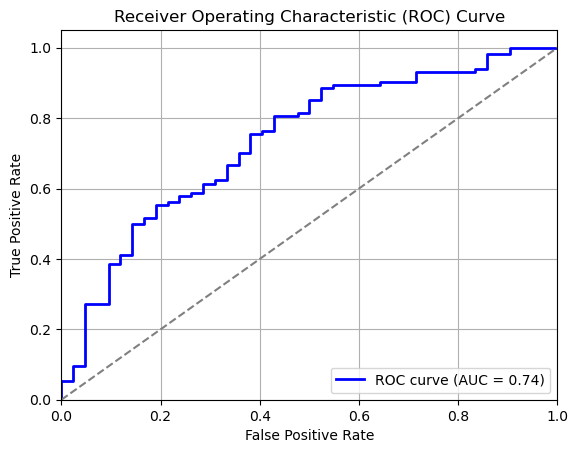

ROC curve data exported to 'roc_curve_data_BreastMNIST.csv'


In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    test_labels.cpu().numpy(), test_probs[:, 1].cpu().numpy()
)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

dataset_name = "BreastMNIST"
roc_data = pd.DataFrame({
    'Dataset': [dataset_name] * len(false_positive_rate),
    'False Positive Rate': false_positive_rate,
    'True Positive Rate': true_positive_rate,
    'Thresholds': thresholds
})
roc_data.to_csv(f'/home/eflammere/BreastCancerQuanvolution/Quantum/checkpoints/trainable/BreastMNIST/28x28/1/roc_curve_data_{dataset_name}.csv', index=False)

print(f"ROC curve data exported to 'roc_curve_data_{dataset_name}.csv'")


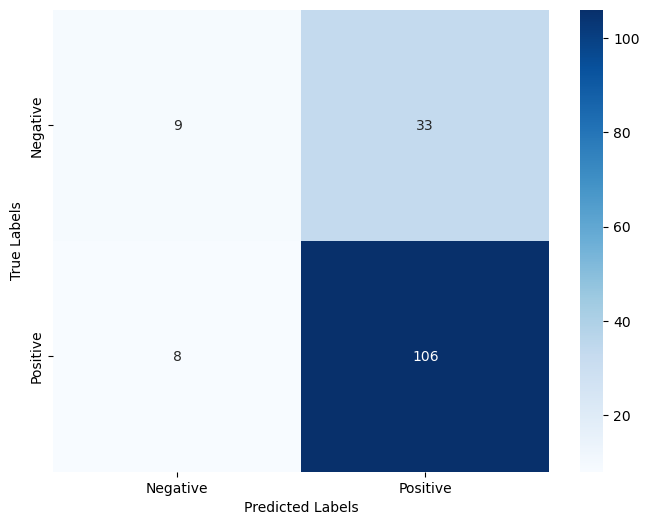

In [ ]:
cm = confusion_matrix(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()